# Part 3. Model Building and Evaluation
-------------------------------------------------------------------------------------------------------------------

## 1. K-Nearest Neighbours Algorithm

### 1) Data Preparation

In [76]:
#------------------------------------------------------------------------------------
# Input dataset : Case 1. 24 features without PCA --> Best Result
#                 Case 2. 8 important features without PCA --> Best Result
#                 Case 3. first 2 components with PCA
#                 Case 4. first 6 components with PCA
#------------------------------------------------------------------------------------

# Import libraries and load cleansed sample dataset
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

loans_sampled = pd.read_csv("./dataset/loans_cleansed_sample.csv")
# ＠Case (1) 8 important features in the Random Forest without PCA
#        - Need to comment PCA reduction codes below
#        - Need to chanage SMOTENC() to SMOTE() below
# --------------------------------------------------------------------------------------
# loans_sampled = pd.read_csv("./dataset/loans_cleansed_sample.csv",
#                            usecols = ['recoveries', 'inq_last_6mths', 'int_rate', 
#                                       'total_pymnt', 'default_loan'])
# loans_sampled = pd.read_csv("./dataset/loans_cleansed_sample.csv",
#                            usecols = ['recoveries', 'inq_last_6mths', 'int_rate', 
#                                       'total_pymnt', 'loan_amnt', 'dti', 'revol_util', 
#                                       'annual_inc', 'default_loan'])
loans_sampled.shape

# Next Steps: 1) Split --> 2) Scaling --> 3) SMOTE --> 4) PCA reduction

(8556, 25)

In [77]:
loans_sampled.shape
# 8 important features: recoveries, inq_last_6mths, int_rate, total_pymnt, loan_amnt, dti, revol_util, annual_inc
# 1 feature: target 'default_loan'

(8556, 25)

In [78]:
# 1) Splitting the dataset into test and train set
from sklearn.model_selection import train_test_split
y = loans_sampled['default_loan']
X = loans_sampled.drop('default_loan', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# 2) Scaling through standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() # mean : 0, standard deviation : 1
sc.fit(X_train) # fit only a train dataset
X_train = sc.transform(X_train)
X_test = sc.transform(X_test) # Do not fit a test dataset

# ***************************************************************************************************
# 3) Oversampling for data that have both categorical and non-categorical attributes
# Data Imbalance - label'0' : 95%, '1' : 5%
# from imblearn.over_sampling import SMOTENC
# ***************************************************************************************************
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
# sm = SMOTENC(random_state = 2020, categorical_features = [9, 23])
sm = SMOTE(random_state = 2020)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

# Check oversampling results
print('After Oversampling, train_X shape : {}'.format(X_train.shape))
print('After Oversampling, train_y shape : {} \n'.format(y_train.shape))

print("After Oversampling, label count '1': {}".format(sum(y_train == 1)))
print("After Oversampling, label count '0': {}".format(sum(y_train == 0)))

# 4) Dimensionality Reduction using PCA(Principal Component Analysis)
# from sklearn.decomposition import PCA
# ***************************************************************************************************
# Adjust input features in the course of model selection
# pca = PCA(n_components = 9) # Test 0.750 Explained variance ratio for first 9 - 13 componets
# pca = PCA(n_components = 2) # ＠ Case (2) the first 2 components
# pca = PCA(n_components = 6) # ＠ Case (3) the first 6 components
# ***************************************************************************************************
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# pca_reduction = pd.DataFrame(data = X_train)

# print(f"explained_variance = {pca.explained_variance_ratio_}") 
# print(f"pca_reduction.shape : {pca_reduction.shape}")

After Oversampling, train_X shape : (11394, 24)
After Oversampling, train_y shape : (11394,) 

After Oversampling, label count '1': 5697
After Oversampling, label count '0': 5697


### 2) Base Model Development

In [79]:
# pca_reduction.head(3)

Working Time: 0.021223668257395426 min


----------------- KNN Performance -----------------


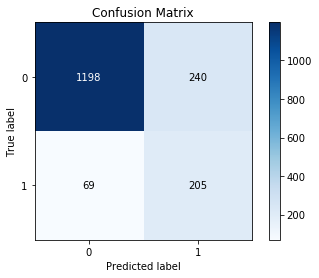

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1438
           1       0.46      0.75      0.57       274

    accuracy                           0.82      1712
   macro avg       0.70      0.79      0.73      1712
weighted avg       0.87      0.82      0.84      1712



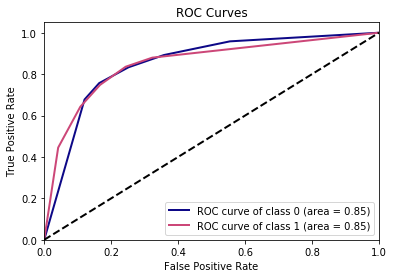

In [80]:
# Lazy KNN base model
from sklearn.neighbors import KNeighborsClassifier
import time
start_time = time.time() # Print Code Running time

# Best parameters: {'weights': 'distance', 'p': 3, 'n_neighbors': 3, 'leaf_size': 8, 'algorithm': 'auto'}
    
model = KNeighborsClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
probas = model.predict_proba(X_test) # Calculate probabilities to draw a ROC curve

# Print Code Running time
print("Working Time: {} min".format((time.time()-start_time)/60))

# Check performance of the model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt 

print("\n\n----------------- KNN Performance -----------------")
skplt.metrics.plot_confusion_matrix(y_test, prediction)
plt.show()
print(classification_report(y_test, prediction))
# Draw the ROC curve
skplt.metrics.plot_roc(y_test, probas, cmap = 'plasma', plot_micro = False, plot_macro = False)
plt.show()

In [81]:
# Check hyperparameters of the base model
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

### 3) Model Validation

In [82]:
# k-fold cross validation
from sklearn.model_selection import cross_val_score, cross_validate
import time
start_time = time.time() # Print Code Running time

# Performance metrics : validate 'accuracy',  among: (1) roc_auc, (2) reacll, (3) f1_score (4) accuracy
metrics = ['roc_auc', 'recall', 'recall_weighted', 'f1_weighted']
for i in range(0, len(metrics)):
    scores = pd.DataFrame(cross_validate(model, X_train, y_train, 
                                         n_jobs = -1, 
                                         cv = 5, 
                                         scoring = metrics,
                                         return_train_score = False))
    print("[%s] average score: %.4f" % (metrics[i], scores['test_'+ metrics[i]].mean()))
    
# Print Code Running time
print("Working Time: {} min".format((time.time()-start_time)/60))

[roc_auc] average score: 0.9665
[recall] average score: 0.9814
[recall_weighted] average score: 0.9078
[f1_weighted] average score: 0.9072
Working Time: 0.43895049889882404 min


In [83]:
# Check scores of all performance metrics
scores.sort_values(by = 'test_roc_auc', ascending = False)

,fit_time,score_time,test_roc_auc,test_recall,test_recall_weighted,test_f1_weighted
1,0.109322,5.547617,0.970134,0.983333,0.912719,0.912282
2,0.062455,5.469514,0.969509,0.983319,0.911326,0.910864
3,0.078078,5.438270,0.969285,0.991220,0.919227,0.918807
4,0.109346,5.360164,0.969141,0.987709,0.899912,0.899135
0,0.187427,4.766553,0.954624,0.961404,0.895614,0.895160


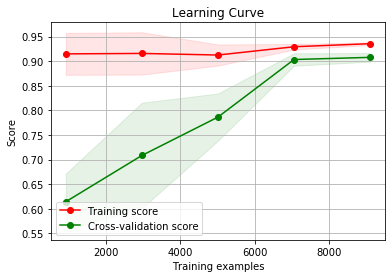

In [84]:
# Learning Curve validation
skplt.estimators.plot_learning_curve(model, X_train, y_train, cv = 5)
plt.show()

[Interpretation]
<ul>
    <li>The graph shows reasonably proper deviation-variance trade-off.</li>
    <li>It seems neither overfitting nor underfitting.</li>
</ul>

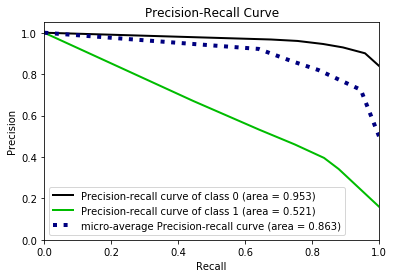

In [85]:
# Precision-Recall Curve validation
skplt.metrics.plot_precision_recall(y_test, probas)
plt.show()

[Interpretation]
<ul>
    <li>Micro-average P-R curve shows as appropirate but class 1 curve area is quite low.</li>
    <li>The balance between Recall and Precision can be made it by improving Precision of class 1.</li>
</ul>

### 4) Hyperparameter Tuning and Model Selection

 ### 4-1. Randomised Search Application

Best score : 0.9740
Best parameters: {'weights': 'distance', 'p': 4, 'n_neighbors': 13, 'leaf_size': 4, 'algorithm': 'ball_tree'}
Working Time: 10.191153168678284 min


----------------- KNN Performance -----------------


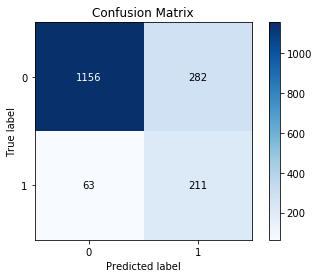

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1438
           1       0.43      0.77      0.55       274

    accuracy                           0.80      1712
   macro avg       0.69      0.79      0.71      1712
weighted avg       0.87      0.80      0.82      1712



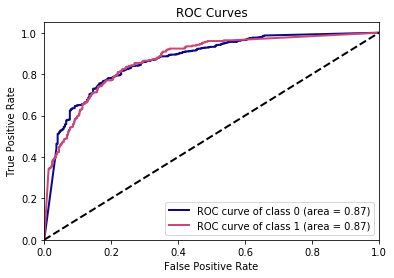

In [86]:
# Randomised Search for Hyperparameter Tuning
# Even faster than Grid Search or Nested CV
from sklearn.model_selection import RandomizedSearchCV
import time
start_time = time.time() # Print Code Running time

# Hyperparameters Set
parameters = {'n_neighbors':[3, 5, 7, 9, 11, 13],
              'leaf_size':[1, 2, 3, 4, 5, 6, 7, 8],
              'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'p':[1, 2, 3, 4, 5]}  

# Run randomized search
n_iteration = 20
rs = RandomizedSearchCV(model, 
                        param_distributions = parameters,
                        n_iter = n_iteration,
                        scoring = 'roc_auc',
                        cv = 5)
rs.fit(X_train, y_train)

result = pd.DataFrame(rs.cv_results_['params'])
result['mean_test_score'] = rs.cv_results_['mean_test_score']
result.sort_values(by = 'mean_test_score', ascending = False)

# Check best parameters
print("Best score : %0.4f" % rs.best_score_)
print(f"Best parameters: {rs.best_params_}")

# Tuned Model construction
model = rs.best_estimator_
model.fit(X_train, y_train)
prediction = model.predict(X_test)
probas = model.predict_proba(X_test)

# Save the model to disk using Pickle
import pickle

filename = './models/final_Model_KNN.sav'
pickle.dump(model, open(filename, 'wb'))

# Check performance of the model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt 

# Print Code Running time
print("Working Time: {} min".format((time.time()-start_time)/60))

print("\n\n----------------- KNN Performance -----------------")
skplt.metrics.plot_confusion_matrix(y_test, prediction)
plt.show()
print(classification_report(y_test, prediction))
# Draw the ROC curve
skplt.metrics.plot_roc(y_test, probas, cmap = 'plasma', plot_micro = False, plot_macro = False)
plt.show()

[Interpretation]
<ul>
    <li>There is a very slight <b><u> difference between a base model and a tuned one.</b></u></li>
</ul>

### 4-2. Grid Search Application

Best score : 0.9817
Best parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}
Working Time: 17.827348224322 min


----------------- KNN Performance -----------------


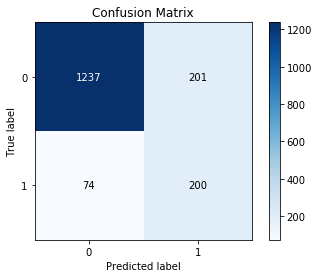

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1438
           1       0.50      0.73      0.59       274

    accuracy                           0.84      1712
   macro avg       0.72      0.80      0.75      1712
weighted avg       0.87      0.84      0.85      1712



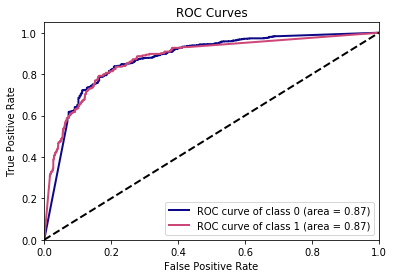

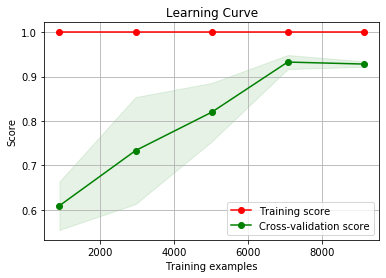

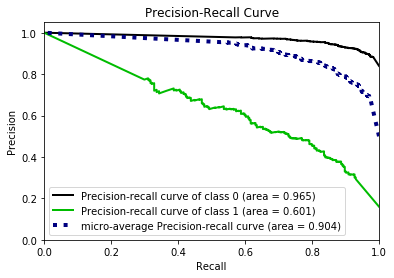

In [87]:
# Grid Search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time() # Print Code Running time

# Hyperparameters Set
# Adjust parameters in order to decrease computational time
parameters = {'n_neighbors':[3, 5, 7, 9, 11, 13],
#               'leaf_size':[1, 2, 3, 4, 5, 6, 7, 8],
#               'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'p':[1, 2, 3, 4, 5]} 

# Focus on 'recall' and 'roc_auc' metrics due to computational complexity
# Sensitiviy is far more important to predict loan defalult than others.
# This requires high level of computing power
gs = GridSearchCV(model, 
                  param_grid = parameters, 
                  scoring = 'roc_auc',
                  n_jobs = -1, 
                  cv = 5)
gs.fit(X_train, y_train)

result = pd.DataFrame(gs.cv_results_['params'])
result['mean_test_score'] = gs.cv_results_['mean_test_score']
result.sort_values(by = 'mean_test_score', ascending = False)

# Check best parameters
print("Best score : %0.4f" % gs.best_score_)
print(f"Best parameters: {gs.best_params_}")

# Tuned Model construction
model = gs.best_estimator_
model.fit(X_train, y_train)
prediction = model.predict(X_test)
probas = model.predict_proba(X_test)

# Check performance of the model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt 

# Print Code Running time
print("Working Time: {} min".format((time.time()-start_time)/60))

print("\n\n----------------- KNN Performance -----------------")
skplt.metrics.plot_confusion_matrix(y_test, prediction)
plt.show()
print(classification_report(y_test, prediction))

# Draw the ROC curve
skplt.metrics.plot_roc(y_test, probas, cmap = 'plasma', plot_micro = False, plot_macro = False)
plt.show()

# Learning Curve validation
skplt.estimators.plot_learning_curve(model, X_train, y_train, cv = 5)
plt.show()

# Precision-Recall Curve validation
skplt.metrics.plot_precision_recall(y_test, probas)
plt.show()

In [88]:
print(f"Best Hyperparameters: \n {model.get_params()}")

Best Hyperparameters: 
 {'algorithm': 'auto', 'leaf_size': 4, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


### 4-3. Nested Cross Validation with Grid Search

CV Average Score: 0.981 +/- 0.005
 CV Scores: [0.97113381 0.9832056  0.98524382 0.98394306 0.98292867]
Best Score: 0.9757985565653041
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}
Working Time: 50.6269727508227 min


----------------- KNN Performance -----------------


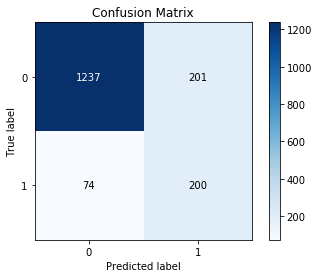

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1438
           1       0.50      0.73      0.59       274

    accuracy                           0.84      1712
   macro avg       0.72      0.80      0.75      1712
weighted avg       0.87      0.84      0.85      1712



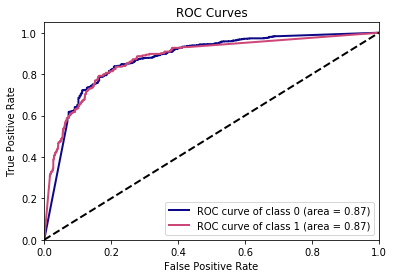

In [89]:
# Nested Cross Validation : 5*2 Cross Validation
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, auc, f1_score, accuracy_score
import time
start_time = time.time() # Print Code Running time

# Hyperparameters Set
# Adjust parameters in order to decrease computational time
parameters = {'n_neighbors':[3, 5, 7, 9, 11, 13],
#               'leaf_size':[1, 2, 3, 4, 5, 6, 7, 8],
#               'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'p':[1, 2, 3, 4, 5]}
# Scoring
nested_gs = GridSearchCV(model, 
                         param_grid = parameters, 
                         scoring = 'roc_auc',
                         n_jobs = -1, 
                         cv = 2)
scores = cross_val_score(nested_gs, 
                         X_train, 
                         y_train, 
                         scoring = 'roc_auc',
                         n_jobs = -1, 
                         cv = 5)

print("CV Average Score: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))
print(f" CV Scores: {scores}")

model = nested_gs.fit(X_train, y_train)
print(f"Best Score: {nested_gs.best_score_}")
print(f"Best Parameters: {nested_gs.best_params_}")

model = nested_gs.best_estimator_
model.fit(X_train, y_train)
prediction = model.predict(X_test)
probas = model.predict_proba(X_test)

# Print Code Running time
print("Working Time: {} min".format((time.time()-start_time)/60))

print("\n\n----------------- KNN Performance -----------------")
skplt.metrics.plot_confusion_matrix(y_test, prediction)
plt.show()
print(classification_report(y_test, prediction))
# Draw the ROC curve
skplt.metrics.plot_roc(y_test, probas, cmap = 'plasma', plot_micro = False, plot_macro = False)
plt.show()

In [90]:
print(f"Best Hyperparameters: \n {model.get_params()}")

Best Hyperparameters: 
 {'algorithm': 'auto', 'leaf_size': 4, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
